### Functional priors from Kepler data
The `PBJam` packages "learns" priors on the parameters of the asymptotic relation from the catalogue of data available on Kepler giants. Can we create something similar using the Santos et al. (2021) catalogue for rotation?


`PBJam` takes in information of numax, dnu, teff and bp_rp to estimate the location of the $l=0,2$ pairs.

We have the probability distribution
$$
P(\theta) = \kappa(\theta)\, 
$$

where $\theta$ are the parameters fit for in a previous study.

Some of these parameters, $\phi$, of which all of $\phi$ are included in $\theta$, can then be evaluated in a likelihood function against the observables.

We should in principle be able to do this using the Santos data, and use the fit on $P$ as the prediction.

Let's start with the Santos et al. catalogue.

In [1]:
import pandas as pd
import numpy as np
from astropy.io import ascii
import seaborn as sns
import matplotlib.pyplot as plt
import astropy.units as u
from astroquery.vizier import Vizier
import warnings
warnings.filterwarnings('ignore')

In [3]:
dat = ascii.read("../Data/apjsac033ft1_mrt.txt")
gf = dat.to_pandas()
len(gf)

39591

We want to exclude:
- Binary CPCB candidates(flag1 != 1)
- Binaries in Gaia catalogues (flag3 == 0)

In [4]:
gf = gf.fillna(-1)

In [5]:
gf = gf[(gf.flag1 != 1) & (gf.flag3 == 0)]
len(gf)

33601

The 2019 catalogue *is* on Vizier-- I'll download it and fold it in. Then we'll xmatch with the Gaia-Kepler fun catalogue for KIC-to-GaiaDR2, then we'll match to DR3 using the DR3 portal. Easy peasy!

In [9]:
cat = Vizier(catalog='J/ApJS/244/21/table3')
cat.ROW_LIMIT = -1
km = cat.get_catalogs(cat.catalog)[0].to_pandas()
km.rename(columns={'Mass':'M', 'E_Mass':'E_M','e_Mass':'e_M'}, inplace=True)
len(km)

15640

In [10]:
km = km[(km.Fl1.isnull()) & (km.Fl3 == 0)]
len(km)

13019

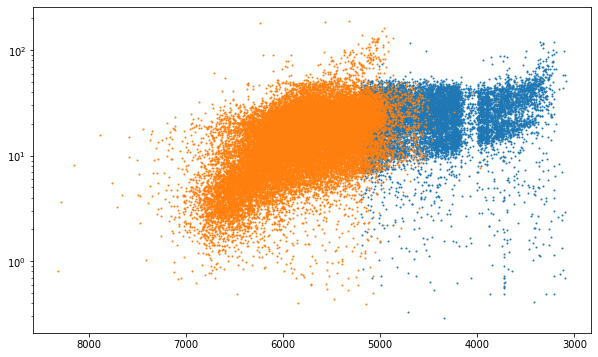

In [11]:
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(km.Teff, km.Prot, label='KM stars', s=1)
ax.scatter(gf.Teff, gf.Prot, label='GF stars', s=1)
ax.invert_xaxis()
ax.set_yscale('log')
# ax.set_xlim(8500)
plt.show()

In [12]:
columns = ['KIC', 'Teff', 'E_Teff', 'e_Teff', 'logg', 'E_logg','e_logg', 'Prot']

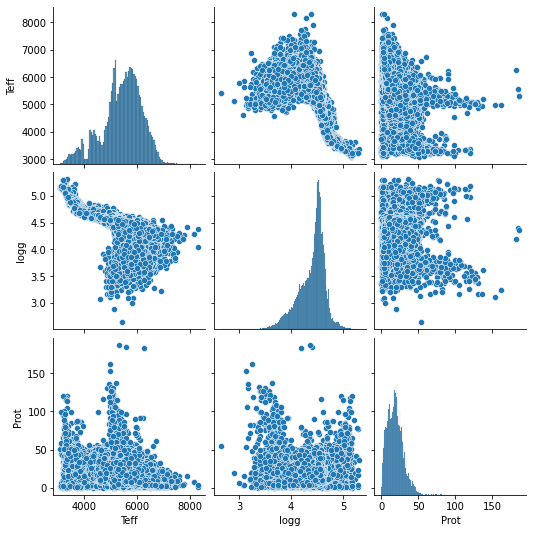

In [13]:
df_full = pd.concat([km[columns], gf[columns]], ignore_index=True)
sns.pairplot(df_full[['Teff', 'logg', 'Prot']])

Now to merge in the Kepler catalogue.

In [16]:
from astropy.table import Table
gkf = Table.read('../Data/kepler_dr2_1arcsec.fits', format='fits')
gkf = gkf[['kepid', 'source_id', 'kepler_gaia_ang_dist']].to_pandas().rename(columns=
                                     {'kepid':'KIC', 'source_id':'source_id_dr2', 'kepler_gaia_ang_dist':'angsep'})

gkf['source_id_dr2'] = gkf['source_id_dr2'].astype(str)
df = df_full.merge(gkf, how='left', on='KIC')
df = df[~df.duplicated('KIC', keep='first')]

print(f'We have {len(df)} / {len(df_full)} stars remaining.')

We have 46620 / 46620 stars remaining.


Get DR3 IDs and EDR3 parallax data.

In [19]:
df[['KIC','source_id_dr2']].to_csv('../Data/dr2xmatchtargetlist.csv', index = False)

In [21]:
columns = ['source_id','ra','dec','parallax',
            'astrometric_params_solved','nu_eff_used_in_astrometry','ruwe',
            'pseudocolour', 'pseudocolour_error',
            'astrometric_gof_al', 'visibility_periods_used',
            'r_med_photogeo', 'r_lo_photogeo','r_hi_photogeo',
            'phot_g_mean_flux', 'phot_g_mean_flux_error', 'phot_g_mean_mag',
            'phot_bp_mean_flux','phot_bp_mean_flux_error','phot_bp_mean_mag',
            'phot_rp_mean_flux','phot_rp_mean_flux_error','phot_rp_mean_mag',
            'bp_rp','angular_distance','kic']
dr3 = pd.read_csv('../Data/santos_x_dr3.csv', index_col=None, usecols=columns)

dr3['source_id'] = dr3.source_id.astype(str)

dr3.rename(columns={'kic':'KIC', 'r_med_photogeo':'r_est'}, inplace=True)

t = dr3.sort_values(by='angular_distance')
index = t[t.duplicated('KIC', keep='first')].index
dr3.drop(index, inplace=True)

In [22]:
df2 = df.merge(dr3, how='left', on='KIC')
print(f'We have {len(df2)} / {len(df_full)} stars remaining.')

We have 46620 / 46620 stars remaining.


In [24]:
df2[['KIC','source_id']].to_csv('../Data/rybizki_xmatch.csv', index=False)

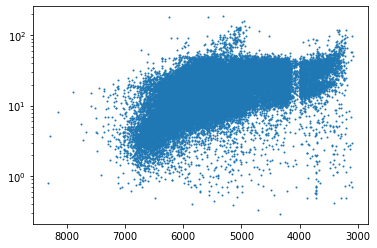

In [25]:
plt.scatter(df2.Teff, df2.Prot, s=1)
plt.yscale('log')
plt.gca().invert_xaxis()

Finally, we need to include additional flags from Rybizki.


In [26]:
df2.source_id = df2.source_id.astype(str)

In [29]:
ryb = pd.read_csv('../Data/rybizki_flags.csv', index_col=None)
ryb.source_id = ryb.source_id.astype(str)
df3 = df2.merge(ryb, how='left', on = 'source_id')

There are 4 cases of duplication remaining. Just dumping these out.

In [30]:
fin = df3[~df3.duplicated('KIC', keep=False)]

In [31]:
fin

,KIC,Teff,E_Teff,e_Teff,logg,E_logg,e_logg,Prot,source_id_dr2,angsep,...,phot_g_mean_mag,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_mag,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_mag,bp_rp,angular_distance,fidelity_v2
0,892834,4940.0,151.0,136.0,4.615,0.032,0.063,13.610000,2050232089348169856,0.111878,...,15.200762,6819.093283,11.629103,15.754226,12551.570637,14.946545,14.501150,1.253076,0.042730,1.0
1,893033,4862.0,145.0,145.0,4.607,0.024,0.060,25.940001,2050232639104043904,0.132399,...,15.262760,6412.969394,11.489936,15.820894,11925.849234,12.317793,14.556672,1.264222,0.045764,1.0
2,1026287,4989.0,151.0,136.0,4.545,0.066,0.044,27.799999,2050236830992083328,0.192481,...,14.931720,8941.002663,11.916792,15.460076,15731.102661,12.527299,14.255998,1.204079,0.013208,1.0
3,1026992,4854.0,145.0,145.0,4.657,0.031,0.058,33.540001,2050238617698593408,0.056258,...,15.810287,3800.717192,9.534883,16.388878,7283.424056,8.571571,15.092056,1.296822,0.031149,1.0
4,1027277,4513.0,121.0,134.0,4.603,0.049,0.025,30.000000,2050238342820749824,0.148469,...,15.700503,3726.632040,8.990775,16.410252,8768.453565,10.348858,14.890588,1.519664,0.040297,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46619,12885457,5934.7,114.4,124.0,3.877,0.054,0.038,20.410000,2139318507152655360,0.129067,...,13.132257,55636.530515,42.138256,13.475143,70581.808499,21.447754,12.626164,0.848979,0.043760,1.0
46620,12934451,5573.0,115.1,109.1,4.079,0.060,0.057,17.470000,2139334278272753664,0.163326,...,14.035011,24846.496284,24.137806,14.350379,33585.264196,21.997414,13.432524,0.917855,0.429196,1.0
46621,12934525,5264.3,95.3,90.7,4.555,0.026,0.039,24.880000,2139334621870145920,0.090778,...,15.542608,5504.718322,16.784380,15.986705,8417.126218,10.773447,14.934986,1.051719,0.024021,1.0
46622,12935035,5878.4,111.1,116.3,3.945,0.056,0.035,19.360000,2139322630321247104,0.131403,...,11.360389,300393.012056,185.208340,11.644318,342211.436669,97.568050,10.912159,0.732159,0.198871,1.0


## Finally, do some correction

In [32]:
# Rybizki flag
s = fin.fidelity_v2 < 1.0

# Ruwe
s += fin.ruwe > 1.25

# Gof cut
s += fin.astrometric_gof_al > 3

# Astrometric visibility cut
s += fin.visibility_periods_used < 9

# Drop NaNs from Gaia data
s += np.isnan(fin.bp_rp)

pri = fin[~s]

In [33]:
def correct_gband(bp_rp, astrometric_params_solved, phot_g_mean_mag, phot_g_mean_flux):
    if np.isscalar(bp_rp) or np.isscalar(astrometric_params_solved) or np.isscalar(phot_g_mean_mag) \
                    or np.isscalar(phot_g_mean_flux):
        bp_rp = np.float64(bp_rp)
        astrometric_params_solved = np.int64(astrometric_params_solved)
        phot_g_mean_mag = np.float64(phot_g_mean_mag)
        phot_g_mean_flux = np.float64(phot_g_mean_flux)
    
    if not (bp_rp.shape == astrometric_params_solved.shape == phot_g_mean_mag.shape == phot_g_mean_flux.shape):
        raise ValueError('Function parameters must be of the same shape!')
    
    do_not_correct = np.isnan(bp_rp) | (phot_g_mean_mag<13) | (astrometric_params_solved == 31)
    bright_correct = np.logical_not(do_not_correct) & (phot_g_mean_mag>=13) & (phot_g_mean_mag<=16)
    faint_correct = np.logical_not(do_not_correct) & (phot_g_mean_mag>16)
    bp_rp_c = np.clip(bp_rp, 0.25, 3.0)
    
    correction_factor = np.ones_like(phot_g_mean_mag)
    correction_factor[faint_correct] = 1.00525 - 0.02323*bp_rp_c[faint_correct] + \
        0.01740*np.power(bp_rp_c[faint_correct],2) - 0.00253*np.power(bp_rp_c[faint_correct],3)
    correction_factor[bright_correct] = 1.00876 - 0.02540*bp_rp_c[bright_correct] + \
        0.01747*np.power(bp_rp_c[bright_correct],2) - 0.00277*np.power(bp_rp_c[bright_correct],3)
    
    gmag_corrected = phot_g_mean_mag - 2.5*np.log10(correction_factor)
    gflux_corrected = phot_g_mean_flux * correction_factor
    
    print(f'Not correcting {len(bp_rp[do_not_correct])} / {len(bp_rp)} stars')
    
    return gmag_corrected, gflux_corrected, correction_factor

In [34]:
pri['Gmag'], fluxcorr, correction_factor = correct_gband(pri.bp_rp, pri.astrometric_params_solved, 
                                      pri.phot_g_mean_mag, pri.phot_g_mean_flux)

Not correcting 37665 / 38010 stars


In [35]:
pri['e_Gmag'] = 2.5 * pri.phot_g_mean_flux_error * correction_factor / (fluxcorr * np.log(10))
pri['e_phot_bp_mean_mag'] = 2.5 * pri.phot_bp_mean_flux_error / (pri.phot_bp_mean_flux * np.log(10))
pri['e_phot_rp_mean_mag'] = 2.5 * pri.phot_rp_mean_flux_error / (pri.phot_rp_mean_flux * np.log(10))
pri['e_bp_rp'] = np.sqrt(pri.e_phot_bp_mean_mag**2 + pri.e_phot_rp_mean_mag**2)
pri['MGna'] = pri.Gmag - 5*np.log10(pri.r_est) + 5
pri['e_r_est'] = np.nanmax([pri.r_lo_photogeo, pri.r_hi_photogeo], axis=0)
pri['e_MGna'] = np.sqrt(pri.e_Gmag**2 + (pri.e_r_est / (pri.r_est * np.log(10)))**2)

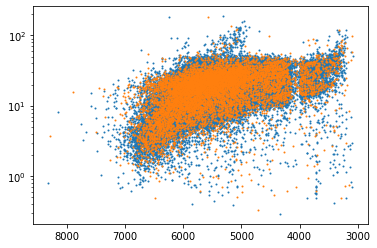

In [36]:
plt.scatter(pri.Teff, pri.Prot, s=1)
plt.yscale('log')
plt.gca().invert_xaxis()
plt.scatter(fin[s].Teff, fin[s].Prot, s=1)

In [40]:
pri.to_csv('../Data/full_prior_data.csv', index=None)

## Finally, let's remove unneeded data

In [42]:
pri['logT'] = np.log10(pri.Teff)
columns = ['logT','logg','Prot','MGna','bp_rp']
train = pri[columns]


In [39]:
print(f'We have {len(pri)} / {len(df_full)} stars remaining.')

We have 38010 / 46620 stars remaining.
